In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
from datetime import datetime
import json

EXP_NAME = "simclr_cifar10_resnet18"
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

BASE_DIR = f"/kaggle/working/{EXP_NAME}/{TIMESTAMP}"
CKPT_DIR = os.path.join(BASE_DIR, "checkpoints")

os.makedirs(CKPT_DIR, exist_ok=True)

config = {
    "dataset": "CIFAR-10",
    "backbone": "ResNet-18",
    "batch_size": 256,
    "projection_dim": 128,
    "temperature": 0.5,
    "optimizer": "Adam",
    "lr": 3e-4,
    "epochs": 70
}

with open(os.path.join(BASE_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

print("Experiment directory:", BASE_DIR)

Experiment directory: /kaggle/working/simclr_cifar10_resnet18/20251223_202630


In [4]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

class SimCLRTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(32),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor()
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

DATA_DIR = "/kaggle/working"

dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=SimCLRTransform()
)

train_loader = DataLoader(
    dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=2,
    drop_last=True
)

100%|██████████| 170M/170M [00:01<00:00, 87.4MB/s] 


In [5]:
import torch.nn as nn
import torchvision.models as models

class SimCLR(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        self.encoder = models.resnet18(weights=None)
        dim = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z

model = SimCLR(config["projection_dim"]).to(device)

In [6]:
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    N = z1.size(0)
    z = torch.cat([z1, z2], dim=0)

    sim = torch.matmul(z, z.T) / temperature

    labels = torch.arange(N, device=z.device)
    labels = torch.cat([labels + N, labels])

    mask = torch.eye(2 * N, device=z.device).bool()
    sim.masked_fill_(mask, -9e15)

    return F.cross_entropy(sim, labels)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

def load_checkpoint(path):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    return ckpt["epoch"] + 1, ckpt["loss_history"]

In [8]:
loss_history = []
start_epoch = 0

for epoch in range(start_epoch, config["epochs"]):
    model.train()
    total_loss = 0

    for (x1, x2), _ in train_loader:
        x1, x2 = x1.to(device), x2.to(device)

        z1 = model(x1)
        z2 = model(x2)

        loss = nt_xent_loss(z1, z2, config["temperature"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {avg_loss:.4f}")

    # ---- SAVE CHECKPOINT ----
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss_history": loss_history,
        "config": config
    }, os.path.join(CKPT_DIR, f"epoch_{epoch:04d}.pth"))

Epoch [1/70], Loss: 5.7919
Epoch [2/70], Loss: 5.6112
Epoch [3/70], Loss: 5.5329
Epoch [4/70], Loss: 5.4584
Epoch [5/70], Loss: 5.4283
Epoch [6/70], Loss: 5.3914
Epoch [7/70], Loss: 5.3723
Epoch [8/70], Loss: 5.3546
Epoch [9/70], Loss: 5.3385
Epoch [10/70], Loss: 5.3276
Epoch [11/70], Loss: 5.3133
Epoch [12/70], Loss: 5.3048
Epoch [13/70], Loss: 5.2902
Epoch [14/70], Loss: 5.2848
Epoch [15/70], Loss: 5.2735
Epoch [16/70], Loss: 5.2661
Epoch [17/70], Loss: 5.2506
Epoch [18/70], Loss: 5.2458
Epoch [19/70], Loss: 5.2399
Epoch [20/70], Loss: 5.2245
Epoch [21/70], Loss: 5.2161
Epoch [22/70], Loss: 5.2124
Epoch [23/70], Loss: 5.2064
Epoch [24/70], Loss: 5.1987
Epoch [25/70], Loss: 5.1903
Epoch [26/70], Loss: 5.1819
Epoch [27/70], Loss: 5.1825
Epoch [28/70], Loss: 5.1737
Epoch [29/70], Loss: 5.1676
Epoch [30/70], Loss: 5.1634
Epoch [31/70], Loss: 5.1627
Epoch [32/70], Loss: 5.1503
Epoch [33/70], Loss: 5.1470
Epoch [34/70], Loss: 5.1436
Epoch [35/70], Loss: 5.1404
Epoch [36/70], Loss: 5.1342
E

In [9]:
torch.save(
    model.encoder.state_dict(),
    os.path.join(BASE_DIR, "encoder_final.pth")
)

print("Encoder saved.")

Encoder saved.


In [10]:
import torch
import torchvision.models as models
import torch.nn as nn

def load_encoder(path, device="cuda"):
    encoder = models.resnet18(weights=None)
    encoder.fc = nn.Identity()
    encoder.load_state_dict(torch.load(path, map_location=device))
    encoder = encoder.to(device)
    encoder.eval()
    return encoder

In [11]:
import glob
import os

BASE_EXP_DIR = "/kaggle/working/simclr_cifar10_resnet18"

# Find all encoder files
encoder_files = glob.glob(
    os.path.join(BASE_EXP_DIR, "*", "encoder_final.pth")
)

assert len(encoder_files) > 0, "No encoder found!"

# Pick the most recent one
ENCODER_PATH = max(encoder_files, key=os.path.getmtime)

print("Loading encoder from:", ENCODER_PATH)

encoder = load_encoder(ENCODER_PATH, device)

Loading encoder from: /kaggle/working/simclr_cifar10_resnet18/20251223_202630/encoder_final.pth


In [12]:
dummy = torch.randn(2, 3, 32, 32).to(device)

with torch.no_grad():
    out = encoder(dummy)

print("Output shape:", out.shape)

Output shape: torch.Size([2, 512])


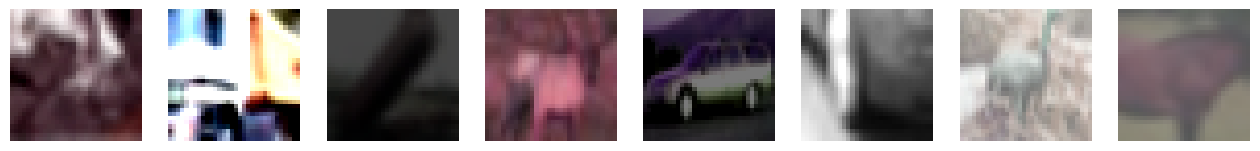

In [13]:
import matplotlib.pyplot as plt

def show_images(dataset, n=8):
    fig, axes = plt.subplots(1, n, figsize=(n*2, 2))
    for i in range(n):
        (img1, _), _ = dataset[i]
        axes[i].imshow(img1.permute(1, 2, 0))
        axes[i].axis("off")
    plt.show()

show_images(dataset)

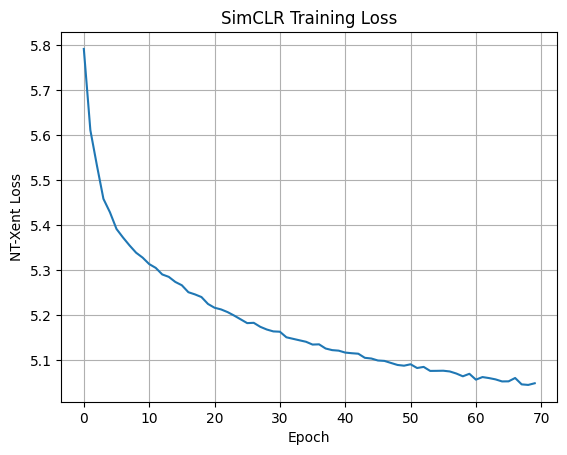

In [15]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
from sklearn.decomposition import PCA
import numpy as np

def extract_features(encoder, dataloader, device):
    features, labels = [], []

    with torch.no_grad():
        for (x1, _), y in dataloader:
            x1 = x1.to(device)
            z = encoder(x1)
            features.append(z.cpu())
            labels.append(y)

    return torch.cat(features), torch.cat(labels)
plt.xlabel("Epoch")
plt.ylabel("NT-Xent Loss")
plt.title("SimCLR Training Loss")
plt.grid(True)
plt.show()

In [16]:
from sklearn.decomposition import PCA
import numpy as np

def extract_features(encoder, dataloader, device):
    features, labels = [], []

    with torch.no_grad():
        for (x1, _), y in dataloader:
            x1 = x1.to(device)
            z = encoder(x1)
            features.append(z.cpu())
            labels.append(y)

    return torch.cat(features), torch.cat(labels)

In [17]:
features, labels = extract_features(encoder, train_loader, device)

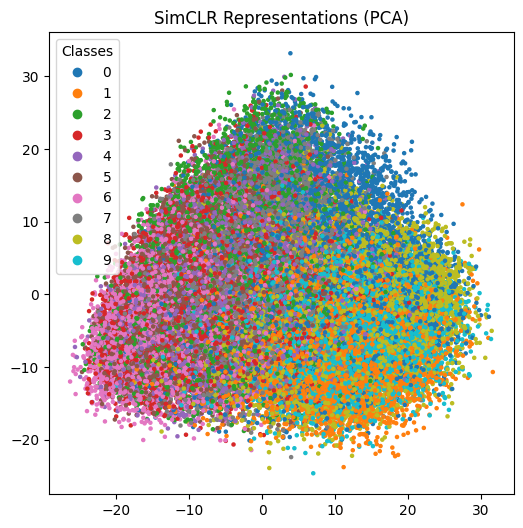

In [18]:
pca = PCA(n_components=2)
proj = pca.fit_transform(features.numpy())

plt.figure(figsize=(6, 6))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=labels, s=5, cmap="tab10")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("SimCLR Representations (PCA)")
plt.show()